In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import theano.tensor as tt

import mogp_emulator


import time

import _pickle as cPickle

from pyComp import *


from cantilever import Cantilever

In [2]:
# Set the number of unknown parameters (i.e. dimension of theta in posterior)
nparam = 3

# Number of draws from the distribution
ndraws = 10000

# Number of burn-in samples
nburn = 1000

# Metropolis tuning parameters
tune = True
tune_interval = 100
discard_tuning = True

# Number of independent chains
nchains = 4

# Do blocked/compounds sampling in Metropolis and MLDA 
# Note: This choice applies only to the coarsest level in MLDA 
# (where a Metropolis sampler is used), all other levels use block sampling
blocked = False

# Set the sigma for inference
sigma_f = 0.05

# Sampling seed
sampling_seed = 12345

# Data seed
data_seed = 123




In [3]:
# Parameters

param = [ None ] * 12

param[0] = 4.5  # E_R   GPa
param[1] = 0.35 # nu_R

param[2] = 135  # E1    GPa
param[3] = 8.5  # E2    GPa
param[4] = 8.5  # E3    GPa

param[5] = 0.022    # nu_21
param[6] = 0.022    # nu_31
param[7] = 0.45     # nu_32

param[8] = 5.0  # G_12 GPa
param[9] = 5.0;   # G_13 GPa
param[10] = 5.0;  # G_23 GPa


param[11] = [np.pi/4, 0.0, 3*np.pi/4]



# Initialised Macro scale model

myModel = Cantilever(param)


print(myModel.baseAngles)




[0.7853981633974483, 0.0, 2.356194490192345]


## Generate Synthetic Data

In [4]:
np.random.seed(data_seed)

data_theta = np.random.normal(0.0, 0.0872665, size = 3)

F_data = myModel.solve(data_theta, plotSolution = True, filename = "data_solution", iterativeSolver = False)

data = F_data + np.random.normal(0.0, sigma_f, size = F_data.shape)

## Build Emulator for misfit



In [5]:
initialSamples = 20

testingSamples = 10

np.random.seed(999) # Fix seed to same initial samples each time.

initialBounds = []

for i in range(nparam):
    initialBounds.append((-0.5, 0.5))
    

lhd = mogp_emulator.LatinHypercubeDesign(initialBounds)

X_init = lhd.sample(initialSamples)

F = []

mu_F = np.zeros(F_data.shape)

cov_F = np.zeros((F_data.shape[0], F_data.shape[0]))

for i in range(initialSamples):
    
    F.append(myModel.solve(X_init[i,:], plotSolution = False, iterativeSolver = False))
    
F_testing = []

X_test = lhd.sample(testingSamples)
for i in range(testingSamples):
    F_testing.append(myModel.solve(X_test[i,:], plotSolution = False, iterativeSolver = False))
    

### Perform Principle Component Analysis on initial samples to reduce the dimension of the output.

In [6]:
numPC = 2

F_array = np.asarray(F)

F_array = np.transpose(F_array)

U, S, _ = np.linalg.svd(F_array, full_matrices=False)

Fhat = []
F_testing_hat = []

for k in range(numPC):
    Fhat.append(np.zeros((initialSamples,)))
    F_testing_hat.append(np.zeros((testingSamples,)))

for i in range(initialSamples):
    for k in range(numPC):
        Fhat[k][i] = np.dot(U[:,k],F[i])
        
for i in range(testingSamples):
    for k in range(numPC):
        F_testing_hat[k][i] = np.dot(U[:,k],F_testing[i])
        


### Train GPs for each principle output component

Floating point error in optimization routine, skipping this iteration


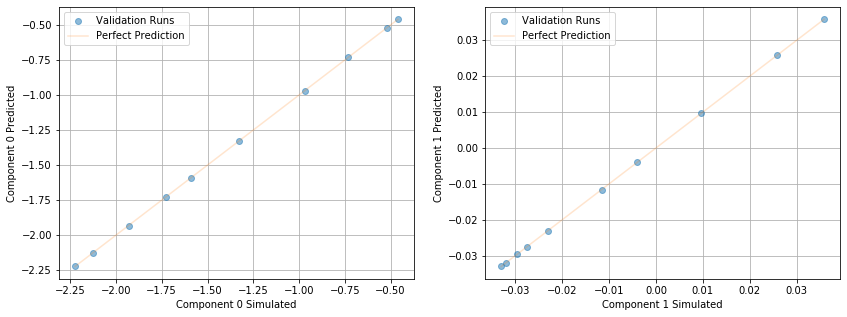

In [7]:
# Next, fit the surrogate GP model using MLE (MAP with uniform priors)
# Print out hyperparameter values as correlation lengths and sigma

gps = []

predictions = []

fig, axs = plt.subplots(1,numPC,figsize=(14,5))

for k in range(numPC):
    
    gps.append(mogp_emulator.GaussianProcess(X_init, Fhat[k])) 
    
    gps[-1].learn_hyperparameters()
    
    predictions.append(gps[-1].predict(X_test))
    
    minF = np.min(F_testing_hat[k])
    maxF = np.max(F_testing_hat[k])
    
    axs[k].plot(F_testing_hat[k],predictions[-1][0],'o',alpha = 0.5, label = 'Validation Runs')
    axs[k].plot(np.linspace(minF,maxF), np.linspace(minF,maxF),'-', alpha = 0.2, label = 'Perfect Prediction')
    axs[k].set_xlabel('Component ' + str(k) + ' Simulated')
    axs[k].set_ylabel('Component ' + str(k) + ' Predicted')
    axs[k].grid(True)
    axs[k].legend()
    
    
plt.show()


In [8]:
# Use a Theano Op along with the code within ./mlda to construct the likelihood

class LogLike(tt.Op):
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, gps, data, U, sigma_f):

        self.gps = gps
        self.data = data
        self.U = U
        self.sigma_f = sigma_f
        
        self.numPC = len(gps)
        
        self.data_hat = np.zeros(self.numPC)
        
        for k in range(numPC):
            self.data_hat[k] = np.dot(U[:,k],data)
        
    def perform(self, node, inputs, outputs):
        
        theta = inputs[0]  # this will contain my variables
        
        misfit = 0.0
        for i in range(self.numPC):       
            misfit += (gps[i].predict(theta)[0] - self.data_hat[i])**2
            
        logl = -0.5 * misfit / (sigma_f**2)
        
        outputs[0][0] = np.array(np.float(logl)) #np.array(logl[[0]]) # output the log-likelihood

In [9]:
# create Theano Ops to wrap likelihood
logl = LogLike(gps, data, U, sigma_f)

In [10]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm
# and passing the coarse_models list created above.

traces = []
runtimes = []
acc = []
ess = []


with pm.Model():
    
    # Define priors on parameters
    param = []
    
    for i in range(nparam):
        param.append(pm.Normal('dtheta_' + str(i), mu = 0.0, sigma = 0.15))
    

    # Convert m and c to a tensor vector
    theta = tt.as_tensor_variable(param)

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    
    # Initialise a demetropolis step method.
    step_demetropolis = pm.DEMetropolis(tune='scaling', tune_interval=tune_interval)

    # Inference! 
    # DEMetropolis
    t_start = time.time()
    traces.append(pm.sample(draws=ndraws, step=step_demetropolis,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed))
    runtimes.append(time.time() - t_start)
    
    

Population sampling (4 chains)
DEMetropolis: [dtheta_2, dtheta_1, dtheta_0]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Population parallelization failed. Falling back to sequential stepping of chains.


The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13f355520>,
      dtype=object)

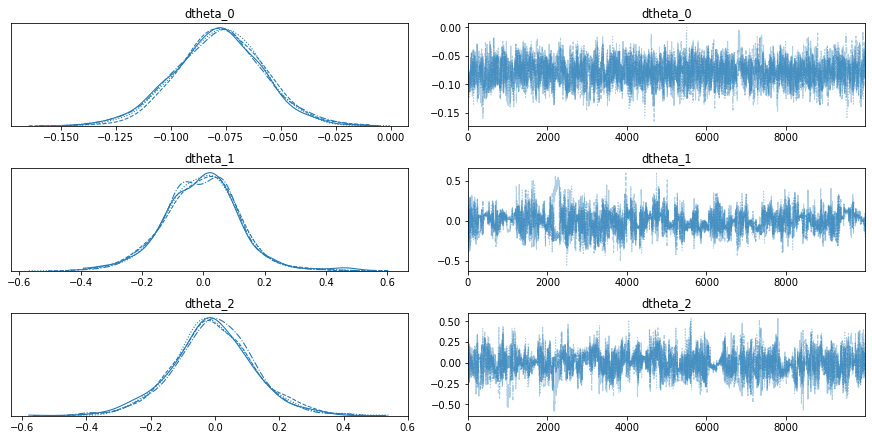

In [11]:
pm.traceplot(traces[0])

In [12]:
print(data_theta)

[-0.09473918  0.08703485  0.02469454]


In [13]:
pm.summary(traces[0])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
dtheta_0,-0.078,0.020,-0.114,-0.04,0.000,0.000,2276.0,2276.0,2292.0,3259.0,1.00
dtheta_1,-0.005,0.120,-0.250,0.20,0.004,0.004,784.0,581.0,787.0,1299.0,1.01
dtheta_2,-0.004,0.127,-0.249,0.24,0.004,0.003,1166.0,1166.0,1130.0,2012.0,1.01
